In [ ]:
#all_no_test
import os
import time
import json
from functools import reduce

import psutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

os.system('pip install neptune-client')
os.system('pip install ../input/pytorchtabnet/pytorch_tabnet-3.1.1-py3-none-any.whl')

from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

import neptune.new as neptune
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
NEPTUNE_API_TOKEN = user_secrets.get_secret("NEPTUNE_API_TOKEN")

from opt_utils import *

ND_NA = 16

cfg = {
    "script_name": 'opt_train_tabnet_142',
    "path_features": '../input/generate-train-features-script-p13/p13_train.pkl', # Used in train mode
    "path_models": '',
    "path_data_raw": '../input/optiver-realized-volatility-prediction/',
    "neptune_project": 'chrisrichardmiles/optiver',
    "neptune_description": 'p13 encoding top columns with shake .3',
    "encode_time_cols": ['real_vol_mean_decay_0.9_-1', 'order_norm_momentum', 'real_vol_mean_decay_0.85_-1', 'real_vol_mean_decay_0.99_1', 'real_vol_mean_decay_0.95_1', 'abs_price_wap_diff_mean_decay_flip', 'abs_price_wap_diff_mean_decay', 'order_norm_sum', 'real_vol_mean_decay_0.85_-1_2', 'spread_mean_decay_flip_95', 'real_vol_mean_decay_0.99_-1', 'real_vol_mean_decay_0.75_-1', 'spread_mean', 'order_count_sum', 'bid_price_diff_count_unique', 'spread_momentum', 'size_mean', 'real_vol_mean_decay_0.95_-1', 'order_norm_mean_decay', 'spread_2_mean_decay_95', 'order_size_mean', 'spread_mean_decay_95', 
                         'spread_pct_momentum'], 
    "encode_stock_cols": ['real_vol_mean_decay_0.9_-1', 'order_norm_momentum', 'real_vol_mean_decay_0.85_-1', 'real_vol_mean_decay_0.99_1', 'real_vol_mean_decay_0.95_1', 'abs_price_wap_diff_mean_decay_flip', 'abs_price_wap_diff_mean_decay', 'order_norm_sum', 'real_vol_mean_decay_0.85_-1_2', 'spread_mean_decay_flip_95', 'real_vol_mean_decay_0.99_-1', 'real_vol_mean_decay_0.75_-1', 'spread_mean', 'order_count_sum', 'bid_price_diff_count_unique', 'spread_momentum', 'size_mean', 'real_vol_mean_decay_0.95_-1', 'order_norm_mean_decay', 'spread_2_mean_decay_95', 'order_size_mean', 'spread_mean_decay_95',
                          'spread_pct_momentum'], 
    "drop_cols": ['row_id', 'time_id', 'stock_id', 'target'] + ['real_momentum_0.55_-1', 'wap_2_last-first', 'sum_bid_ask_momentum', 'abs_log_return_momentum', 'order_size_sqaure_weighted_sum', 'size_mean_decay_95', 'size_norm_momentum_95', 'size_norm_momentum', 'size_spread_mean_decay_flip_95', 'log_return_2_realized_volatility', 'abs_price_wap_diff_2_std', 'sum_bid_ask_mean', 'real_momentum_0.85_-1', 'real_vol_mean_decay_0.55_-1', 'abs_price_wap_diff_amax', 'size_mean_decay', 'real_vol_mean_decay_0.9_-1_2', 'abs_price_wap_diff_2_mean', 'real_momentum_0.65_-1_2', 'price_wap_diff_2_max_sub_min', 'real_vol_mean_decay_0.75_1', 'real_vol_min_5', 'real_vol_mean_decay_0.95_-1_2', 'real_vol_min_6', 'size_spread_mean', 'size_spread_mean_decay_95', 'real_vol_mean_decay_0.75_1_2', 'sum_bid_ask_std', 'price_wap_diff_mean_decay', 'wap_2_real_vol', 'abs_price_wap_diff_2_mean_decay', 'size_momentum_95', 'real_momentum_0.65_-1', 'size_spread_momentum_95', 'real_vol_min_2', 'sum_bid_ask_mean_decay_flip', 'real_vol_mean_decay_0.65_1', 'size_spread_mean_decay_flip', 'real_momentum_0.75_-1_2', 'abs_price_wap_diff_2_max_sub_min', 'price_wap_diff_momentum', 'real_momentum_0.55_-1_2', 'real_momentum_0.45_-1_2', 'spread_pct_std', 'abs_price_wap_diff_max_sub_min', 'real_momentum_0.95_-1', 'real_vol_min_7', 'real_vol_min_4_2', 'real_vol_mean_decay_0.99_1_2', 'spread_2_sum', 'sum_bid_ask_mean_decay', 'real_vol_mean_decay_0.55_1', 'real_vol_mean_decay_0.55_1_2', 'real_vol_mean_decay_0.9_1_2', 'real_vol_mean_decay_0.65_1_2', 'real_vol_mean_decay_0.45_1_2', 'wap_2_std', 'price_wap_diff_max_sub_min', 'real_momentum_0.85_-1_2', 'real_momentum_0.45_-1', 'price_wap_diff_2_mean_decay_flip', 'size_norm_mean_decay_flip_95', 'price_wap_diff_mean_decay_flip', 'real_momentum_0.99_-1', 'sum_bid_ask_max_sub_min', 'real_vol_mean_decay_0.95_1_2', 'real_vol_min_4', 'real_vol_min_8', 'real_vol_min_2_2', 'real_momentum_0.99_-1_2', 'real_momentum_0.95_-1_2', 'log_return_mean_decay_flip', 'real_vol_mean_decay_0.85_1_2', 'price_wap_diff_2_std', 'log_return_realized_volatility', 'abs_log_return_2_momentum', 'log_return_2_mean_decay_flip', 'log_return_std', 'log_return_2_std', 'real_momentum_0.75_-1', 'real_vol_mean_decay_0.45_-1_2', 'abs_price_wap_diff_2_momentum', 'real_momentum_0.9_-1_2', 'real_vol_mean_decay_0.9_1', 'price_wap_diff_2_mean_decay', 'real_vol_min_9_2', 'real_vol_mean_decay_0.99_-1_2', 'wap_2_max_sub_min', 'real_momentum_0.9_-1', 'dummy3', 'abs_price_wap_diff_2_mean_decay_flip', 
                                                               'abs_log_return_2_std'],
    "encode_funcs": ['mean', 'std'], 
    "shake": False, 
    "shake_std": .3, 
    "prefix": '',
    "rerun": True,
    "neptune_run_name": '',
}
with open('cfg.json', 'w') as f: 
    json.dump(cfg, f)
    
cfg['tabnet_params'] = {
        'cat_emb_dim': 1,
        'n_d': ND_NA,
        'n_a': ND_NA,
        'n_steps': 2,
        'gamma': 2,
        'n_independent': 2,
        'n_shared': 2,
        'lambda_sparse': 0,
        'optimizer_fn': Adam,
        'optimizer_params': {'lr': 0.02},
        'mask_type': 'entmax',
        'scheduler_params': {
            'T_0': 200,
            'T_mult': 1,
            'eta_min': 0.0001,
            'last_epoch': -1,
            'verbose': False
        },
        'scheduler_fn': CosineAnnealingWarmRestarts,
        'seed': 42,
        'verbose': 10
    }

def RMSPELoss(y_pred, y_true):
    return torch.sqrt(torch.mean(((y_true - y_pred) / y_true) ** 2 )).clone()

class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))
    
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)
print(psutil.cpu_count())

Wed Sep 22 07:11:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def main(): 
    train = pd.read_pickle(cfg['path_features'])
    train.replace([np.inf, -np.inf], np.nan,inplace=True)
    train = train.fillna(train.mean())
    train = encode_cols(train, cfg["encode_time_cols"], funcs=cfg['encode_funcs'], on='time_id')

    # Saving encoded stock columns != 'stock_id']
    drop_cols = [c for c in cfg['drop_cols'] if c != 'stock_id']
    x = train.drop(drop_cols, axis = 1)
    y = train['target']
    

    # dict_eval_logs = [] # For experimentation tracking
    # booster_summaries = [] # For experimentation tracking

    oof_predictions = np.zeros(x.shape[0]) # Create out of folds array
    scores = [] # Keep track of scores for each fold and all oof at the end
    best_iterations = []
    training_best_scores = []
    valid_best_scores = [] # Same as scores in this script, but would be different with nested cv
    best_score_diffs = []
    rmspe_logs = []
    loss_logs = []

    feature_importances = pd.DataFrame()
    
#     stats = pd.DataFrame()
#     explain_matrices = []
#     masks_ = []

    for fold in range(5):
        trn_ind = x.fold != fold
        val_ind = x.fold == fold

        print(f'Training fold {fold}')
        x_train, x_val = x[trn_ind].drop('fold', axis=1), x[val_ind].drop('fold', axis=1)
        y_train, y_val = y[trn_ind].values.reshape(-1, 1), y[val_ind].values.reshape(-1, 1)

        x_train = encode_cols(x_train, 
                              cfg['encode_stock_cols'], 
                              funcs=cfg['encode_funcs'], 
                              shake=cfg['shake'], 
                              shake_std=cfg['shake_std']).drop('stock_id', axis=1)
        if fold == 0: feature_importances["feature"] = x_train.columns.tolist()
        x_train = x_train.values
        n_train_cols = x_train.shape[1]
        

        x_val = encode_cols(x_val, 
                            cfg['encode_stock_cols'], 
                            funcs=cfg['encode_funcs']).drop('stock_id', axis=1).values

        clf =  TabNetRegressor(**cfg['tabnet_params'])
        clf.fit(
          x_train, y_train,
          eval_set=[(x_val, y_val)],
          max_epochs = 400,
          patience = 50,
          batch_size = 2 ** 12, 
          virtual_batch_size = 2 ** 10,
          num_workers = 4,
          drop_last = False,
          eval_metric=[RMSPE],
          loss_fn=RMSPELoss
          )

        clf.save_model(os.path.join(cfg['path_models'], f'{cfg["prefix"]}tab_fold_{fold}'))
        y_pred = clf.predict(x_val).flatten()
        oof_predictions[val_ind] = y_pred
        scores.append(round(rmspe(y_val.flatten(), y_pred), 3))
        
#         explain_matrix, masks = clf.explain(x_val)
#         explain_matrices.append(explain_matrix)
#         masks_.append(masks[0])
#         masks_.append(masks[1])

        feature_importances[f"fold_{fold}"] = clf.feature_importances_

#         stats[f'fold{fold+1}_train_rmspe']=clf.history['loss']
#         stats[f'fold{fold+1}_val_rmspe']=clf.history['val_0_rmspe']

        # clf_ =  TabNetRegressor(**tabnet_params)
        # clf_.load_model('./tab_fold_0.zip')

        best_iterations.append(clf.best_epoch)
        train_score = clf.history['loss'][clf.best_epoch]
        valid_score = clf.best_cost
        training_best_scores.append(round(train_score, 3))
        valid_best_scores.append(round(valid_score, 3))
        best_score_diffs.append(round(valid_score - train_score, 3))

        rmspe_logs.append(clf.history['val_0_rmspe'])
        loss_logs.append(clf.history['loss'])

    rmspe_score = round(rmspe(y, oof_predictions), 3)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    print(f'Our cv fold scores are {scores}')
    np.save('oof_predictions', oof_predictions)

    run = neptune.init(
            project=cfg['neptune_project'],
            api_token=NEPTUNE_API_TOKEN,
            name=cfg['neptune_run_name'],    
            description=cfg['neptune_description'],
            tags=[cfg['path_features'], cfg['prefix']],
            source_files=['cfg.json'],
    )
    
    run['cfg'] = cfg
    cfg['feat_file'] = 'enc_' + os.path.split(cfg['path_features'])[1]
    run['RMSPE'] = rmspe_score
    run['RMSPE_oof_scores'] = scores
    run['RMSPE_cv_std'] = np.std(scores)

    run['best_iterations'] = best_iterations
    run['oof_predictions'] = oof_predictions
    best_iterations_mean = int(np.mean(best_iterations))
    run['best_iterations_mean'] = best_iterations_mean
    run['training_best_scores'] = training_best_scores
    run['valid_best_scores'] = valid_best_scores
    run['best_score_diffs'] = best_score_diffs
    run['best_score_diffs_mean'] = round(np.mean(best_score_diffs), 3)
    
    # Feature importance
    cols = [c for c in list(feature_importances) if c.startswith('fold_')]
    feature_importances['mean_importance'] = feature_importances[cols].mean(axis=1)
    feature_importances.sort_values(by='mean_importance', ascending=False, inplace=True)
    fig, ax = plt.subplots()
    sns.barplot(y=feature_importances['feature'][:25],x=feature_importances['mean_importance'][:25], palette='inferno', ax=ax)
    plt.title('Mean Feature Importance by Folds')
    run['feature_importance'].upload(fig)

    # Logs for each folds model
    for fold in range(5):
        for val in rmspe_logs[fold]:
            run[f'eval_logs/{fold}_rmspe'].log(val)
        for val in loss_logs[fold]:
            run[f'eval_logs/{fold}_loss'].log(val)
        run[f'models/fold_{fold}/model_params'].upload('./model_params.json')
        run[f'models/fold_{fold}/network'].upload('./network.pt')

    run.stop()

    # if cfg['rerun']: 
    #     print(f'retraining model with all data for {best_iterations} iterations')
    #     params = cfg['lgb_params'].copy()
    #     params['early_stopping_rounds'] = 0 # No valid set to stop with

    #     x_train = x.drop(['fold'], axis=1)
    #     x_train = encode_cols(x_train, 
    #                           cfg['encode_stock_cols'], 
    #                           funcs=cfg['encode_funcs'], 
    #                           shake=cfg['shake'], 
    #                           shake_std=cfg['shake_std']).drop('stock_id', axis=1)
    #     y_train = y

    #     assert(n_train_cols == x_train.shape[1])

    #     train_weights = 1 / np.square(y_train) # Root mean squared percentage error weights
    #     train_dataset = lgb.Dataset(x_train, y_train, weight=train_weights)

    #     for fold, best_iter in enumerate(best_iterations): 
    #         params['n_estimators'] = int(best_iter) # lgbm needs int here
    #         model = lgb.train(params = params, 
    #                           train_set = train_dataset)
    #         model.save_model(os.path.join(cfg['path_models'], f'{cfg["prefix"]}rerun_lgb_{fold}.txt'))

Training fold 0
Device used : cuda
epoch 0  | loss: 34.84265| val_0_rmspe: 3.97562 |  0:00:09s
epoch 10 | loss: 0.25115 | val_0_rmspe: 0.64807 |  0:01:45s
epoch 20 | loss: 0.24029 | val_0_rmspe: 0.22786 |  0:03:22s
epoch 30 | loss: 0.22001 | val_0_rmspe: 0.22581 |  0:05:01s
epoch 40 | loss: 0.22145 | val_0_rmspe: 0.22225 |  0:06:38s
epoch 50 | loss: 0.2176  | val_0_rmspe: 0.22428 |  0:08:17s
epoch 60 | loss: 0.21214 | val_0_rmspe: 0.23971 |  0:09:52s
epoch 70 | loss: 0.2109  | val_0_rmspe: 0.21874 |  0:11:28s
epoch 80 | loss: 0.21048 | val_0_rmspe: 0.21648 |  0:13:05s
epoch 90 | loss: 0.2065  | val_0_rmspe: 0.22274 |  0:14:39s
epoch 100| loss: 0.20502 | val_0_rmspe: 0.22282 |  0:16:12s
epoch 110| loss: 0.20462 | val_0_rmspe: 0.2217  |  0:17:45s
epoch 120| loss: 0.20281 | val_0_rmspe: 0.21807 |  0:19:19s
epoch 130| loss: 0.20293 | val_0_rmspe: 0.21796 |  0:20:53s

Early stopping occurred at epoch 135 with best_epoch = 85 and best_val_0_rmspe = 0.21598
Best weights from best epoch are au

Waiting for the remaining 1481 operations to synchronize with Neptune. Do not kill this process.


All 1481 operations synced, thanks for waiting!


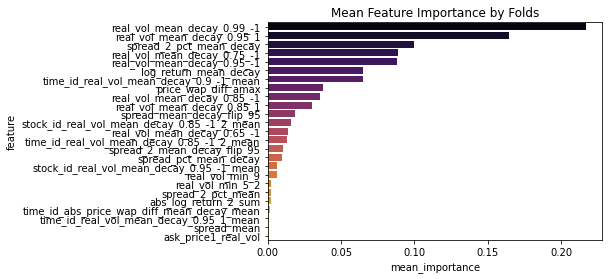

In [ ]:
if __name__ == '__main__': 
    main()

In [ ]:
# import shutil
# shutil.copy('../input/tmp3zip/model_params.json', 'model_params.json')
# shutil.copy('../input/tmp3zip/network.pt', 'network.pt')

# z = zipfile.ZipFile('tmp.zip', 'w')
# z.write('model_params.json')
# z.write('network.pt')
# z.close()
# tmp.load_model('tmp.zip')